In [19]:
#MAE271D Project
# MPC

from algames import ALGAMES
from mpc import MPC

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

In [20]:
# M players
M = 3

# N horizon length
N = 10

# n state size
n = 4  # (x, y, v_x, v_y)

# m control input size
m = 2  # (a_x, a_y)

# timestep
dt = 0.1 

# collision avoidance radius
r = 0.33

# running cost matrix
Q = np.diag([0, 0, 0, 0])

# terminal cost matrix
Qf = np.diag([0, 5, 2, 2])

# control cost matrix
R = np.diag([0.001, 0.1])


# # running cost matrix
# Q = np.eye(n)

# # terminal cost matrix
# Qf = np.eye(n) * 100

# # control cost matrix
# R = np.eye(m)

# penalty gain
rho = 1

# penalty schedule
gamma = 10

# convergence tolerance
eps = 1e-5

# max iterations
max_iter = 20

# multiplier to enforce dynamics
dynamics_mult = 100

In [ ]:
# ### GENERAL EXAMPLE ICs###
# # # initial state
# x1_0 = np.array([0, 0, 1, 1.75])
# x2_0 = np.array([0, -0.5, 1, 2])
# x3_0 = np.array([0.5, 0.25, 0.5, 1])
# list_x0 = [x1_0, x2_0, x3_0]

# # final state
# x1_f = np.array([1.5, 0, 2, 0])
# x2_f = np.array([2, 0, 2, 0])
# x3_f = np.array([2.5, 0, 2, 0])
# list_xf = [x1_f, x2_f, x3_f]

### LANE MERGE ICs ###
# initial state
x1_0 = np.array([1, 0, 1.5, 0])
x2_0 = np.array([0.1, 0, 1.5, 0])
x3_0 = np.array([0.1, 0.5, 2, 0])
list_x0 = [x1_0, x2_0, x3_0]

# final state
x1_f = np.array([3, 0, 2, 0])
x2_f = np.array([2, 0, 2, 0])
x3_f = np.array([2.5, 0, 2, 0])
list_xf = [x1_f, x2_f, x3_f]

# constraints
constraint_wall_y = 1
constraint_u_x_max = 5
constraint_u_y_max = constraint_u_x_max

In [22]:
X_mpc, U_mpc = MPC(
        M,  # number players
        N,  # horizon
        n,  # state size
        m,  # control input size
        dt,  # timestep
        r,  # collision avoidance radius
        list_x0,  # list of initial states
        list_xf,  # list of target states
        Q,  # running cost matrix
        Qf,  # terminal cost matrix
        R,  # control cost matrix
        rho,  # constraint penalty value
        gamma,  # constraint penalty schedule
        eps,  # convergence tolerance
        constraint_wall_y,  # y value of horizontal wall
        constraint_u_x_max,  # control input x bound
        constraint_u_y_max,  # control input y bound
        max_iter,
        dynamics_mult,
    )

0 y_max=2.75 rho=1 C_vio=-0.0
1 y_max=2.75 rho=10 C_vio=-0.0
2 y_max=2.75 rho=100 C_vio=-0.0
3 y_max=2.75 rho=1000 C_vio=-0.0
4 y_max=2.75 rho=10000 C_vio=-0.0
5 y_max=2.75 rho=100000 C_vio=-0.0
6 y_max=2.75 rho=1000000 C_vio=-0.0
7 y_max=2.75 rho=10000000 C_vio=-0.0
8 y_max=2.75 rho=100000000 C_vio=-0.0
9 y_max=2.75 rho=1000000000 C_vio=-0.0
10 y_max=2.75 rho=10000000000 C_vio=-0.0
0 y_max=2.927 rho=1 C_vio=-0.0
1 y_max=2.927 rho=10 C_vio=-0.0
2 y_max=2.927 rho=100 C_vio=-0.0
3 y_max=2.927 rho=1000 C_vio=-0.0
4 y_max=2.927 rho=10000 C_vio=-0.0
5 y_max=2.927 rho=100000 C_vio=-0.0
6 y_max=2.927 rho=1000000 C_vio=-0.0
7 y_max=2.927 rho=10000000 C_vio=-0.0
8 y_max=2.927 rho=100000000 C_vio=-0.0
9 y_max=2.927 rho=1000000000 C_vio=-0.0
10 y_max=2.927 rho=10000000000 C_vio=-0.0
11 y_max=2.927 rho=100000000000 C_vio=-0.0
12 y_max=2.927 rho=1000000000000 C_vio=-0.0
13 y_max=2.927 rho=10000000000000 C_vio=-0.0
14 y_max=2.927 rho=100000000000000 C_vio=-0.0
15 y_max=2.927 rho=1000000000000000 C_v

Text(0.5, 1.0, 'Position')

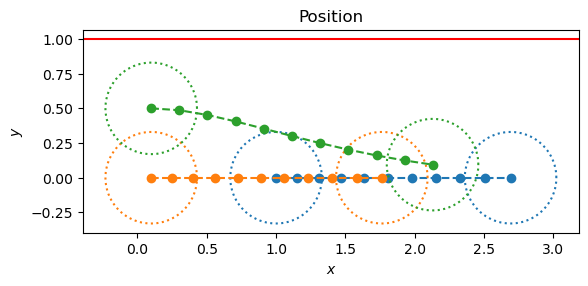

In [23]:
x_players = np.split(X_mpc, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

# plot
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    plt.plot(x[0, :], x[1, :], "o--")

    # plot cola radius
    plt.plot(x[0, 0] + c_cos, x[1, 0] + c_sin, ":", c=f"C{i}")
    plt.plot(x[0, -1] + c_cos, x[1, -1] + c_sin, ":", c=f"C{i}")
plt.axhline(constraint_wall_y, c="r")
plt.gca().set_aspect("equal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")

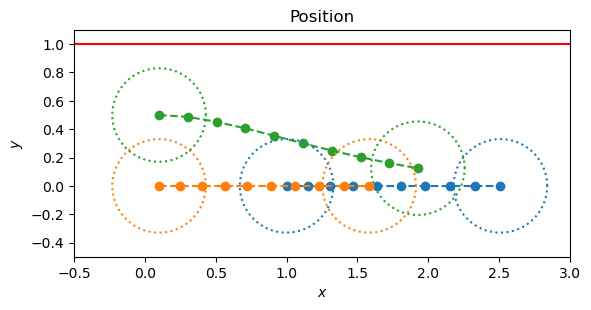

In [24]:
x_players = np.split(X_mpc, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

player1 = np.reshape(x_players[0], (n, N+1), order="F")
player2 = np.reshape(x_players[1], (n, N+1), order="F")
player3 = np.reshape(x_players[2], (n, N+1), order="F")

# animation of trajectory
fig = plt.figure()
writer = PillowWriter(fps = 3)

plt.axhline(constraint_wall_y, c="r")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")
plt.xlim([-0.5, 3.0])
plt.ylim([-0.5, 1.1])

line1, = plt.plot([], [], "o--", color = "tab:blue")
line2, = plt.plot([], [], "o--", color = "tab:orange")
line3, = plt.plot([], [], "o--", color = "tab:green")

line1_x = []
line1_y = []
line2_x = []
line2_y = []
line3_x = []
line3_y = []
      
with writer.saving(fig, "mpc_no_noise.gif", 300):
        for i in range(N):
                line1_x.append(player1[0,i])
                line1_y.append(player1[1,i])
                line2_x.append(player2[0,i])
                line2_y.append(player2[1,i])
                line3_x.append(player3[0,i])
                line3_y.append(player3[1,i])

                line1.set_data(line1_x, line1_y)
                line2.set_data(line2_x, line2_y)
                line3.set_data(line3_x, line3_y)

                # plot cola radius @ beginning & end
                if (i == 0) or (i==N-1):
                        plt.plot(line1_x[i] + c_cos, line1_y[i] + c_sin, ":", color = "tab:blue")
                        plt.plot(line2_x[i] + c_cos, line2_y[i] + c_sin, ":", color = "tab:orange")
                        plt.plot(line3_x[i] + c_cos, line3_y[i] + c_sin, ":", color = "tab:green")
                
                plt.gca().set_aspect("equal")

                writer.grab_frame()

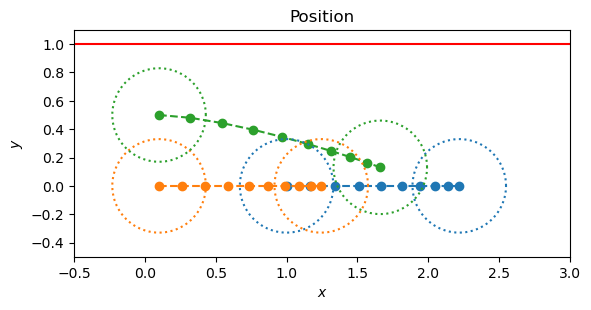

In [6]:
player1 = np.reshape(x_players[0], (n, N+1), order="F")
player2 = np.reshape(x_players[1], (n, N+1), order="F")
player3 = np.reshape(x_players[2], (n, N+1), order="F")

# animation of trajectory
fig = plt.figure()
writer = PillowWriter(fps = 3)

plt.axhline(constraint_wall_y, c="r")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")
plt.xlim([-0.5, 3.0])
plt.ylim([-0.5, 1.1])

line1, = plt.plot([], [], "o--", color = "tab:blue")
line2, = plt.plot([], [], "o--", color = "tab:orange")
line3, = plt.plot([], [], "o--", color = "tab:green")

line1_x = []
line1_y = []
line2_x = []
line2_y = []
line3_x = []
line3_y = []
      
with writer.saving(fig, "mpc_no_noise.gif", 300):
        for i in range(N):
                line1_x.append(player1[0,i])
                line1_y.append(player1[1,i])
                line2_x.append(player2[0,i])
                line2_y.append(player2[1,i])
                line3_x.append(player3[0,i])
                line3_y.append(player3[1,i])

                line1.set_data(line1_x, line1_y)
                line2.set_data(line2_x, line2_y)
                line3.set_data(line3_x, line3_y)

                # plot cola radius @ beginning & end
                if (i == 0) or (i==N-1):
                        plt.plot(line1_x[i] + c_cos, line1_y[i] + c_sin, ":", color = "tab:blue")
                        plt.plot(line2_x[i] + c_cos, line2_y[i] + c_sin, ":", color = "tab:orange")
                        plt.plot(line3_x[i] + c_cos, line3_y[i] + c_sin, ":", color = "tab:green")
                
                plt.gca().set_aspect("equal")

                writer.grab_frame()

In [7]:
# determine if merged or not
# define "merged" as within a  1/10 radius of desired y - final position for all players

merged = 0
merged_tol = 1/5

x_f_small = [x1_f[1], x2_f[1], x3_f[1]]

for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    x_f = x[:,-1][1:2]
    print(x_f)
    print(x_f - x_f_small[i])
    print("hi")
    if abs(x_f - x_f_small[i]) < merged_tol:
        merged = 1
    else:
        merged = 0
    print(merged)

[-2.12722188e-12]
[-2.12722188e-12]
hi
1
[1.02563983e-16]
[1.02563983e-16]
hi
1
[0.10246773]
[0.10246773]
hi
1


Text(0.5, 0.98, 'Velocity')

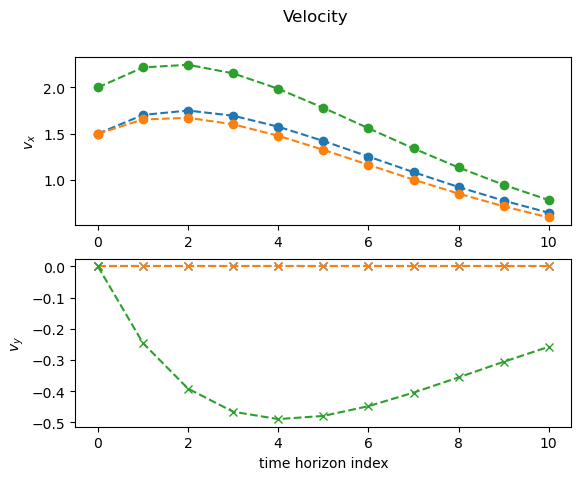

In [8]:
# velocity
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    ax = plt.subplot(211)
    ax.plot(x[2, :], "o--", c=f"C{i}")
    plt.ylabel('$v_x$')
    ax = plt.subplot(212)
    ax.plot(x[3, :], "x--", c=f"C{i}")
    plt.ylabel('$v_y$')
plt.xlabel('time horizon index')
plt.suptitle("Velocity")

Text(0.5, 0.98, 'Control input')

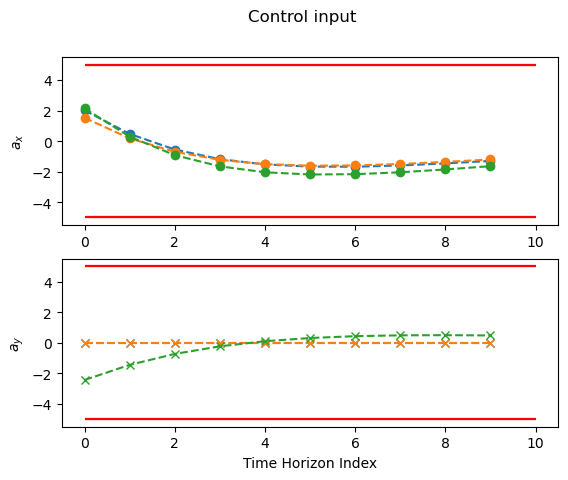

In [9]:
u_players = np.split(U_mpc, M)

# plot
plt.figure()
for i, u in enumerate(u_players):
    u = np.reshape(u, (m, N+1), order="F")
    ax = plt.subplot(211)
    plt.plot(u[0, 1:], "o--", c=f"C{i}")
    plt.hlines((constraint_u_x_max, -constraint_u_x_max), 0, N, "r")
    plt.ylabel('$a_x$')
    ax = plt.subplot(212)
    plt.plot(u[1, 1:], "x--", c=f"C{i}")
    plt.hlines((constraint_u_y_max, -constraint_u_y_max), 0, N, "r")
    plt.ylabel('$a_y$')
plt.xlabel('Time Horizon Index')
plt.suptitle("Control input")